### Lập trình mạng nơ ron hồi tiếp từ đầu
- Trong phần này, ta lập trình từ đầu mô hình ngôn ngữ được giới thiệu trong chương trước. Mô hình này dựa trên mạng nơ ron hồi tiếp ở cấp độ ký tự được huấn luyện trên tiểu thuyết The Time Machine. Ta bắt đầu với việc đọc tập dữ liệu.

In [1]:
from d2l import torch as d2l
import math
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
data = d2l.TimeMachine(batch_size, num_steps)

In [2]:
print(data.vocab.token_freqs)

[(' ', 32775), ('e', 17838), ('t', 13515), ('a', 11704), ('i', 10138), ('n', 9917), ('o', 9758), ('s', 8486), ('h', 8257), ('r', 7674), ('d', 6337), ('l', 6146), ('m', 4043), ('u', 3805), ('c', 3424), ('f', 3354), ('w', 3225), ('g', 3075), ('y', 2679), ('p', 2427), ('b', 1897), ('v', 1295), ('k', 1087), ('x', 236), ('z', 144), ('j', 97), ('q', 95)]


In [3]:
data_iter = data.get_dataloader(train = True)


In [4]:
# In ra một minibatch
for X, y in data_iter:
    print(X, y)
    break

tensor([[ 0, 21,  9,  ...,  2, 13,  0],
        [ 0,  2,  0,  ...,  6,  5, 10],
        [ 6,  6,  0,  ..., 15,  4, 10],
        ...,
        [20, 10, 16,  ...,  0, 24,  2],
        [17, 10, 15,  ...,  0, 20, 22],
        [20,  0,  2,  ...,  6, 13, 13]]) tensor([[21,  9, 10,  ..., 13,  0, 20],
        [ 2,  0, 13,  ...,  5, 10,  4],
        [ 6,  0, 10,  ...,  4, 10,  2],
        ...,
        [10, 16, 15,  ..., 24,  2, 26],
        [10, 15,  8,  ..., 20, 22, 19],
        [ 0,  2, 13,  ..., 13, 13,  6]])


#### 1. Biểu diễn one hot

Kích thước minibatch mà ta lấy mẫu ở mỗi lần là __(Kích thước batch, bước thời gian)__. Hàm one_hot biển đổi một minibatch như vậy thành một tensor 3 chiều với kích thước chiều cuối cùng bằng bộ từ vựng. Chúng ta thường xuyên chuyển vị đầu vào để có đầu ra với kích thước __(bước thời gian, kích thước batch, kích thước bộ từ vựng)__ phù hợp hơn để đưa vào mô hình chuỗi.

#### 2. Khởi tạo tham số mô hình
- Tiếp theo ta khởi tạo các tham số cho mô hình RNN. Số nút ẩn num_hiddens là tham số có thể điều chỉnh.

#### 3. Mô hình RNN

- Đầu tiên ta khởi tạo trạng thái ẩn bằng hàm init_rnn_state. Hàm này trả về tuple gồm một ndarray chứa giá trị 0 và có kích thước là (kích thước batch, số nút ẩn). 
- Trả về tuple giúp ta dễ dàng xử lý các tính huống khi trạng thái ẩn có nhiều biến (Ví dụ ta cần khởi tạp nhiều tầng được kết hợp trong rnn).

Hàm rnn sau định nghĩa cách tính toán trạng thái ẩn và đầu ra tại một bước thời gian. Hàm kích hoạt ở đây là tanh. Giá trị trung bình của hàm tanh là 0, khi các phần tử được phân bố đều trên trục số thực.

Có thể thấy kích thước đầu ra là (số bước x kích thước batch, kích thước bộ từ vựng), trong khi kích thước trạng thái ẩn vẫn giữ nguyên là (kích thước batch, số nút ẩn)

#### 4. Dự đoán
- Trước tiên ta tạo hàm dự đoán thường xuyên được dùng để kiểm tra trong quá trình huấn luyện. Hàm này dự đoán num_prediects ký tự tiếp theo dựa trên prefix (một chuỗi chứa một vài ký tự). Ở các ký tự đầu tiên trong chuỗi, ta chỉ cập nhật trạng thái ẩn rồi sau đó mới bắt đầu tạo ra các ký tự mới.

#### 5. Gọt gradient
- Với chuỗi độ dài T, trong vong lặp lan truyền ngược ta tính toán gradient T qua T bước thời gian, dẫn đến một chuỗi các tích của ma trận có độ phức tạo O(T). Khi T lớn thì việc này có thể dẫn đến mất ổn định số học, biểu hiện qua hiện tượng bùng nổ hoặc tiêu biến gradient. 
- Khi giải quyết vấn đề tối ưu, ta thực hiện cập nhật trọng số w ngược hướng gradient trên một minibatch theo công thức . Giả sử hàm mục tiêu là hàm liên tục Lipschitz với hằng số L, tức là:
    
    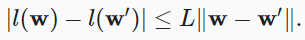

- Trong trường hợp này, có thể nói khi cập nhật vector trọng số theo eta * g_t, sự thay đổi sẽ không lớn hơn L * eta * ||g_t||. Điều này vừa có lợi vừa có hại, có hại ở chỗ tốc độ tối ưu bị giới hạn, có lợi ở chỗ mức độ sai lệch khi tối ưu sai hướng sẽ bị hạn chế.

- Đôi khi gradient có thể khá lớn và do đó thuật toán tối ưu không hội tụ. Vấn đề này có thể được giải quyết bằng cách giảm tốc độ học hoặc sử dụng một số thủ thuật liên quan đến đạo hàm bậc cao hơn.
- Nhưng nếu gradient hiếm khi đạt giá trị lớn, cách giải quyết như vậy không đảm bảo hội tụ hoàn toàn, một cách khá là sử dụng gradient clipping bằng cách chiếu gradient lên bằng cầu bán kính theta qua công thức:

    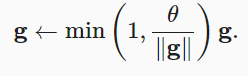

- Như vậy chuẩn của gradient sẽ không vượt quá theta và gradient sau khi gọt sẽ cùng hướng gradient ban đầu. 
- Gradient clipping có tác dụng tích cực là hạn chế ảnh hưởng quá lớn của bất kỳ minibatch nào lên các trọng số, làm cho mô hình ổn định hơn. Dù không giải quyết được hoàn toàn vấn đề, đây là một kỹ thuật đơn giản để làm giảm nhẹ vấn đề bùng nổ gradient.

#### 6. Huấn luyện
- Trước tiên, ta định nghĩa hàm huấn luyện trên môt epoch dữ liệu, quá trình huấn luyện này khác với những quá trình trước ở các điểm như sau:
    1. Các phương pháp lấy mẫu khác nhau cho dữ liệu tuần tự (lấy mẫu ngẫu nhiên và phân tách tuần tự) sẽ dẫn đến sự khác biệt trong việc khởi tạo các trạng thái ẩn.
    2. Ta gọt gradient trước khi cập nhật tham số mô hình. Việc này đảm bảo rằng mô hình sẽ không phân kỳ ngay cả khi gradient bùng nổ tại một thời điểm nào đó trong quá trình huấn luyện, đồng thời tự động giảm biên độ của bước cập nhật một cách hiệu quả.
    3. Ta sử dụng perplexity để đánh giá mô hình. Phương pháp này đảm bảo rằng các chuỗi có độ dài khác nhau có thể so sánh được.
- Khi thực hiện lấy mẫu tuần tự, ta chỉ khởi tạo trạng thái ẩn khi bắt đầu mỗi epoch. Vì mẫu thứ i trong minibatch tiếp theo liền kề với mẫu thứ i trong minibatch hiện tại nên ta có thể sử dụng trực tiếp trạng thái ẩn cho minibatch tiếp theo, chỉ cần tách gradient để tính riêng cho mỗi minibatch. 
- Còn khi thực hiện lấy mẫu ngẫu nhiên, ta cần tái khởi tạo trạng thái ẩn cho mỗi vòng lặp vì mỗi mẫu được lấy ra ở vị trí ngẫu nhiên.

Bây giờ ta có thể huấn luyện mô hình. Do chỉ sử dụng 10000 token trong tập dữ liệu, mô hình này cần nhiều epoch hơn để hội tụ.

In [5]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [6]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [7]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [8]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [9]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [10]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

In [11]:
@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

In [12]:
@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [13]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

In [14]:
@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

KeyboardInterrupt: 

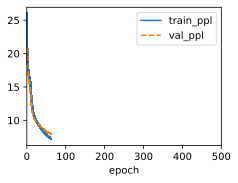

In [15]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=500, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [16]:
@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [17]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the the the the '

In [18]:
list(model.parameters())

[Parameter containing:
 tensor([[-4.1323e-01,  3.2072e-01, -3.7517e-01,  3.7847e-02,  1.5230e-01,
           4.4930e-01, -4.9677e-01,  7.0976e-02,  6.3526e-01,  2.4421e-01,
          -1.9077e-01,  3.4947e-01,  5.3597e-01, -2.3626e-01, -1.5516e-01,
          -6.0821e-02, -1.4239e-01, -1.9041e-01,  2.9590e-01, -6.2166e-01,
          -3.4567e-01, -1.5843e-01, -9.2922e-02,  2.3644e-01,  7.5824e-02,
          -1.7608e-02, -1.9250e-01,  3.0550e-01],
         [-2.9963e-01,  6.5981e-02,  3.5332e-01, -1.1427e-01, -2.5880e-01,
           2.4856e-01,  4.1174e-01,  1.3245e-01, -2.6416e-01, -2.5836e-02,
          -2.1109e-01,  1.1471e-01, -2.5653e-02,  1.8903e-01, -7.7323e-02,
          -1.9834e-01, -2.8957e-01, -3.9834e-02,  9.1872e-02,  3.3902e-01,
          -8.9560e-02, -4.3529e-01,  8.7319e-02, -2.6149e-01, -3.3297e-02,
           4.1506e-01,  9.3770e-02,  4.3778e-02],
         [-1.5496e-01, -3.2128e-01,  2.6920e-01, -1.4939e-01,  9.0164e-02,
           2.2708e-01,  6.4667e-01, -1.6960e-01,  2.